#### Handle the imports

In [1]:
from nipype import Node, Workflow
from nipype.interfaces import freesurfer, fsl, mrtrix
from nipype.interfaces.dcm2nii import Dcm2nii
from nipype.interfaces.io import DataFinder

In [2]:
from multiprocessing import cpu_count
import numpy as np
import logging

#### Define a function for the preprocessing workflow

In [ ]:
# def preproc_sub(subject_folder, subject_id):

#### Start the logging

In [3]:
logger = logging.getLogger('interface')
logger.setLevel(logging.DEBUG)
# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)

#### Define the later function variables in hard-code for debuging

In [4]:
subject_folder = '/Users/srothmei/Desktop/charite/toronto/'
subject_id = 'FR_20120903'

## Set parameters and build variables

In [5]:
reconallFolderName = 'recon_all' # Define what the output folder of recon-all should be named
subPath = subject_folder + '/' + subject_id # Build full path to subject folder

wf = Workflow(name = 'preprocSub')

#### RawData Structure

In [6]:
rawdataFolder = subPath + '/RAWDATA' # Define the path to the folder holding the rawdata dicom-files
T1RawFolder = rawdataFolder + '/MPRAGE/' # The T1 rawdata folder
dwiRawFolder = rawdataFolder + '/DTI' # The dwMRI rawdata folder
fmriRawFolder = rawdataFolder + '/BOLD-EPI/' # The fMRI rawdata folder

In [7]:
logger.info('Start the preprocessing for subject ' + subject_id)

2015-10-30 17:45:21,647 - INFO - Start the preprocessing for subject FR_20120903
INFO:interface:Start the preprocessing for subject FR_20120903


### Structural Data (T1) preprocessing

In [8]:
logger.info('Start recon_all')

# Get the first DICOM file from the set of T1 raw-images
df = DataFinder(root_paths = T1RawFolder, match_regex = '.*\.dcm')
firstFile = df.run().outputs.out_paths[0]
# Set recon-all parameters
reconallInterface = freesurfer.preprocess.ReconAll()
reconallInterface.inputs.T1_files = firstFile
reconallInterface.inputs.subjects_dir = subPath
reconallInterface.inputs.subject_id = reconallFolderName
reconallInterface.inputs.directive = 'all'
reconallInterface.inputs.openmp = cpu_count()

reconall = Node(reconallInterface, name = 'reconall')

mc = freesurfer.preprocess.MRIConvert()
#mc.inputs.in_file = subPath + reconallFolderName + '/mri/aparc+aseg.mgz'
mc.inputs.out_file = subPath + reconallFolderName + '/mri/aparc+aseg.nii.gz'
mc.inputs.out_type = 'niigz'
mc.inputs.out_orientation = 'RAS'

convertT1 = Node(mc, name = 'convertT1')

# Connect the nodes in the workflow
wf.connect(reconall, 'T1', convertT1, 'in_file')

T1 = subPath + reconallFolderName + '/mri/T1.mgz'

2015-10-30 17:45:23,037 - INFO - Start recon_all
INFO:interface:Start recon_all


DEBUG:interface:{'DISPLAY': ':1'}
INFO:workflow:Converting dotfile: /Users/srothmei/Documents/TVB-Pypeline/notebooks/workflow_graph.dot to png format


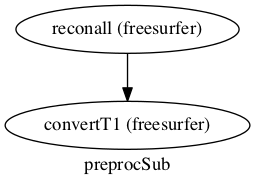

In [11]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="workflow_graph.dot.png")
#from matplotlib import image as Image
#print(wf.write_graph.__doc__)

### Diffusion Data (dwMRI) preprocessing

In [ ]:
logger.info('Start dt_recon')

# First extract the diffusion vectors and the pulse intensity (bvec and bval)
# Use dcm2nii for this task.
# dcm2nii -g -i -d N -e N DTI/*.dcm
# Find all dwMRI DICOM files
df.inputs.root_paths = dwiRawFolder
dwMriDicoms = df.run().outputs.out_paths

converter = Dcm2nii()
converter.inputs.source_names = dwMriDicoms
converter.inputs.gzip_output = True
converter.inputs.output_dir = dwiRawFolder
converter.run()
